# Network embedding via GConv-AE

In this notebook we aim to derive a node embedding for the regulatory network of U2OS cells that we derived in our preceeding analyses. To this end, we will train a graph-convolutional autoencoder of the same latent dimension size as our image embeddings namely 1024. The GAE model will be trained on the task of reconstructing the network structure and the gene expression data. Note that we treat the embedding of the network as a preprocessing step similar to proposed spectral embedding to allow downstream tasks such as node clustering. Thus, we will train the model on the full network and not leave out e.g. any nodes for validation or testing. We will later show that the derived embeddings can be used to effectively solve a proxy node classification task for validation.

---

## 0. Environmental setup

First, we will load all required libraries.

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import sys
import os
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import community as community_louvain
from torch_geometric.data import Data
from torch import LongTensor, FloatTensor
from node2vec import Node2Vec
from torch_geometric.nn import GAE
from torch_geometric.utils import train_test_split_edges, from_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import InnerProductDecoder
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import scanpy as sc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import adjusted_mutual_info_score
from scipy.stats import spearmanr, pearsonr
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer

from scipy.spatial.distance import pdist, squareform
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

sys.path.append("../../../")

from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *
from src.utils.basic.io import get_genesets_from_gmt_file
from src.models.ae import CustomGAE, GCNEncoder

seed = 1234

plt.style.use("default")

%load_ext nb_black

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we will read in the regulatory graph data along side with a scRNA-seq data set and a number of hallmark geneset information. The latter two will be used to define further node features and update the correlation information for the interactions in the graph.

In [118]:
spearman_interactome = nx.read_gpickle(
    "../../../data/ppi/inference_results/cv/conf_hub_spearman_sol_cv.pkl"
)
print(nx.info(spearman_interactome))

Name: conf_hub_spearman_sol
Type: Graph
Number of nodes: 244
Number of edges: 521
Average degree:   4.2705


<IPython.core.display.Javascript object>

In [3]:
gex_adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
gex_adata.var_names_make_unique()
gex_data = pd.DataFrame(
    gex_adata.X, columns=gex_adata.var_names, index=gex_adata.obs_names
)
gex_data.columns = [c.upper() for c in gex_data.columns]
gex_data = gex_data.loc[
    :, set(spearman_interactome.nodes()).intersection(gex_data.columns)
]

<IPython.core.display.Javascript object>

In addition to the 50 Hallmark gene sets, we also load the gene sets corresponding to pathways involved in mechanotransduction: cell cycle control, regulation of chromatin organization and actin cytoskeleton, DNA damage repair, cell death and transcription factors.

In [41]:
cc_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_cycle.txt", index_col=0).index
)
co_genes = set(
    pd.read_csv("../../../data/other/reactome_chrom_org.txt", index_col=0).index
)
dr_genes = set(
    pd.read_csv("../../../data/other/reactome_dna_repair.txt", index_col=0).index
)
cd_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_death.txt", index_col=0).index
)
cr_genes = set(
    pd.read_csv("../../../data/other/kegg_reg_act_cytoskeleton.txt", index_col=0).index
)
tfs = set(pd.read_csv("../../../data/other/human_tf_list.txt", index_col=0).index)

spec_results = pd.read_csv(
    "../../../data/other/specificity_screen_results_cv.csv", index_col=0
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)
hallmark_geneset_dict = get_genesets_from_gmt_file(
    "../../../data/other/h.all.v7.4.symbols.gmt"
)

<IPython.core.display.Javascript object>

---
---

## 2. Preprocessing

We will now set the respective node and edge attributes computed based on the previously loaded information. Note, that the single-cell gene expression data is min-max-scaled.

### 2.1. Attribute setting

In [5]:
gex_data_z = pd.DataFrame(
    MinMaxScaler().fit_transform(gex_data.transpose()),
    index=gex_data.transpose().index,
    columns=gex_data.transpose().columns,
).transpose()

<IPython.core.display.Javascript object>

In [6]:
for node in spearman_interactome.nodes(data=True):
    node[-1]["sc_gex"] = np.array(gex_data_z.loc[:, node[0]])
    node[-1]["sc_gex"] = node[-1]["sc_gex"]
    node[-1]["name"] = node[0]
    node[-1]["cell_cycle"] = node[0] in cc_genes
    node[-1]["chromatin_org"] = node[0] in co_genes
    node[-1]["dna_repair"] = node[0] in dr_genes
    node[-1]["cytoskeleton_org"] = node[0] in cr_genes
    node[-1]["cell_death"] = node[0] in cd_genes
    node[-1]["tf"] = node[0] in tfs
    node[-1]["spec_target"] = node[0] in spec_orf_targets

    gene_memberships = []
    for geneset in hallmark_geneset_dict.values():
        if node[0] in geneset:
            gene_memberships.append(1.0)
        else:
            gene_memberships.append(0.0)

    node[-1]["hallmark"] = np.array(gene_memberships)
    node[-1]["sc_gex_hallmark"] = np.concatenate(
        [node[-1]["sc_gex"], node[-1]["hallmark"]]
    )

for edge in spearman_interactome.edges(data=True):
    edge[-1]["spearmanr"] = spearmanr(
        gex_data.loc[:, edge[0]], gex_data.loc[:, edge[1]]
    )[0]
    edge[-1]["pearsonr"] = pearsonr(gex_data.loc[:, edge[0]], gex_data.loc[:, edge[1]])[
        0
    ]

<IPython.core.display.Javascript object>

---

### 2.2 Data preparation

Next, we transform the graph into a data object complient with the used pytorch_geometric framework to learn the graph embeddings.

In [7]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

graph_data = from_networkx(spearman_interactome)
graph_data.id = torch.FloatTensor(np.identity(len(spearman_interactome)))
graph_data = T.ToDevice(
    device,
    attrs=[
        "id",
        "sc_gex",
        "pbulk_gex",
        "hallmark",
        "sc_gex_hallmark",
        "pbulk_gex_hallmark",
    ],
)(graph_data)

<IPython.core.display.Javascript object>

---
---

## 3. Node embeddings


After having finally prepared the data, we can now start inferring node embeddings from the data. To assess the stability of the latent spaces we will train a two-layer GAE with a four-layer feature decoder using 5 different random initilaization for a maximum of 1000 epochs until the training loss no longer goes down.


After training, we assess the similarity between the inferred latent spaces by pairwise comparing the hierarchical co-clustering of the inferred spaces pairwise using the adjusted mutual information.

---

##### Hallmark-GEX GAE (adjacency & feature reconstruction)

We train the model on the adjacency and feature reconstruction task.

In [8]:
seeds = [1234, 2345, 3456, 4567]

<IPython.core.display.Javascript object>

Latent dim: 1024


  8%|▊         | 843/10000 [00:17<03:08, 48.63it/s]


Training stopped after 844 epochs
Best model found at epoch 642
------------------------------------------------------------
TRAIN loss: 0.8833990693092346
VAL loss: 1.1020801067352295
TEST loss: 1.1211155652999878
TEST AUC: 0.8251664201183432 	 AP: 0.8735130149375525


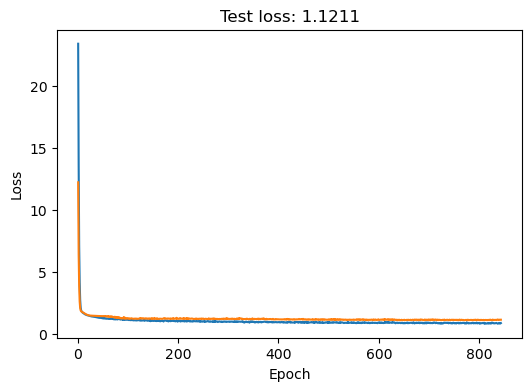

 11%|█         | 1055/10000 [00:22<03:10, 47.02it/s]


Training stopped after 1056 epochs
Best model found at epoch 854
------------------------------------------------------------
TRAIN loss: 0.8747537732124329
VAL loss: 1.116793155670166
TEST loss: 1.109140396118164
TEST AUC: 0.8365384615384615 	 AP: 0.876844234261031


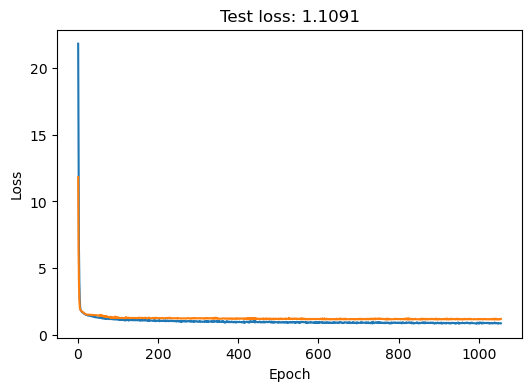

 10%|█         | 1005/10000 [00:20<03:00, 49.80it/s]


Training stopped after 1006 epochs
Best model found at epoch 804
------------------------------------------------------------
TRAIN loss: 0.8746321797370911
VAL loss: 1.1242117881774902
TEST loss: 1.0929546356201172
TEST AUC: 0.8411612426035503 	 AP: 0.8815920592566696


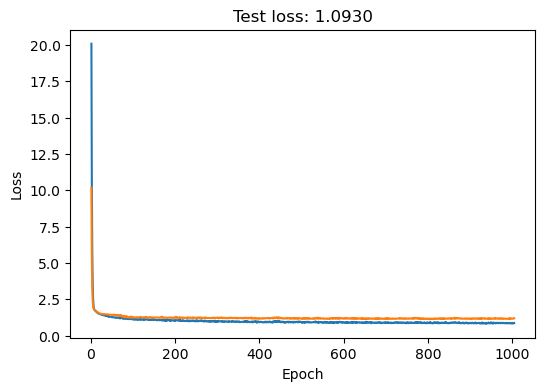

  9%|▉         | 915/10000 [00:18<03:07, 48.48it/s]


Training stopped after 916 epochs
Best model found at epoch 714
------------------------------------------------------------
TRAIN loss: 0.8588839173316956
VAL loss: 1.083709716796875
TEST loss: 1.1076246500015259
TEST AUC: 0.8416235207100592 	 AP: 0.8792641496985824


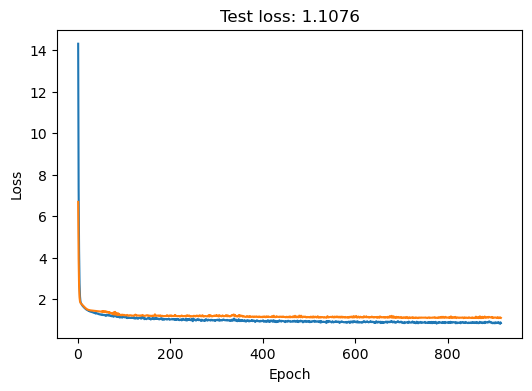

<IPython.core.display.Javascript object>

In [48]:
node_feature_key = "sc_gex_hallmark"

print("Latent dim: {}".format(1024))
latents_dict_hallgexgae_feat = get_gae_latents_for_seed(
    graph_data=graph_data,
    seeds=seeds,
    node_feature_key=node_feature_key,
    input_dim=1176,
    latent_dim=1024,
    hidden_dim=512,
    n_epochs=10000,
    lr=0.0001,
    split_type="link",
    reconstruct_features=True,
    feature_decoder_params={
        "latent_dim": 1024,
        "output_dim": 1176,
        "hidden_dims": [1024, 1024, 1024],
    },
    feat_loss=torch.nn.L1Loss(),
    alpha=1,
    beta=1,
    plot_loss=True,
    early_stopping=200,
)

100%|██████████| 4/4 [00:15<00:00,  3.97s/it]


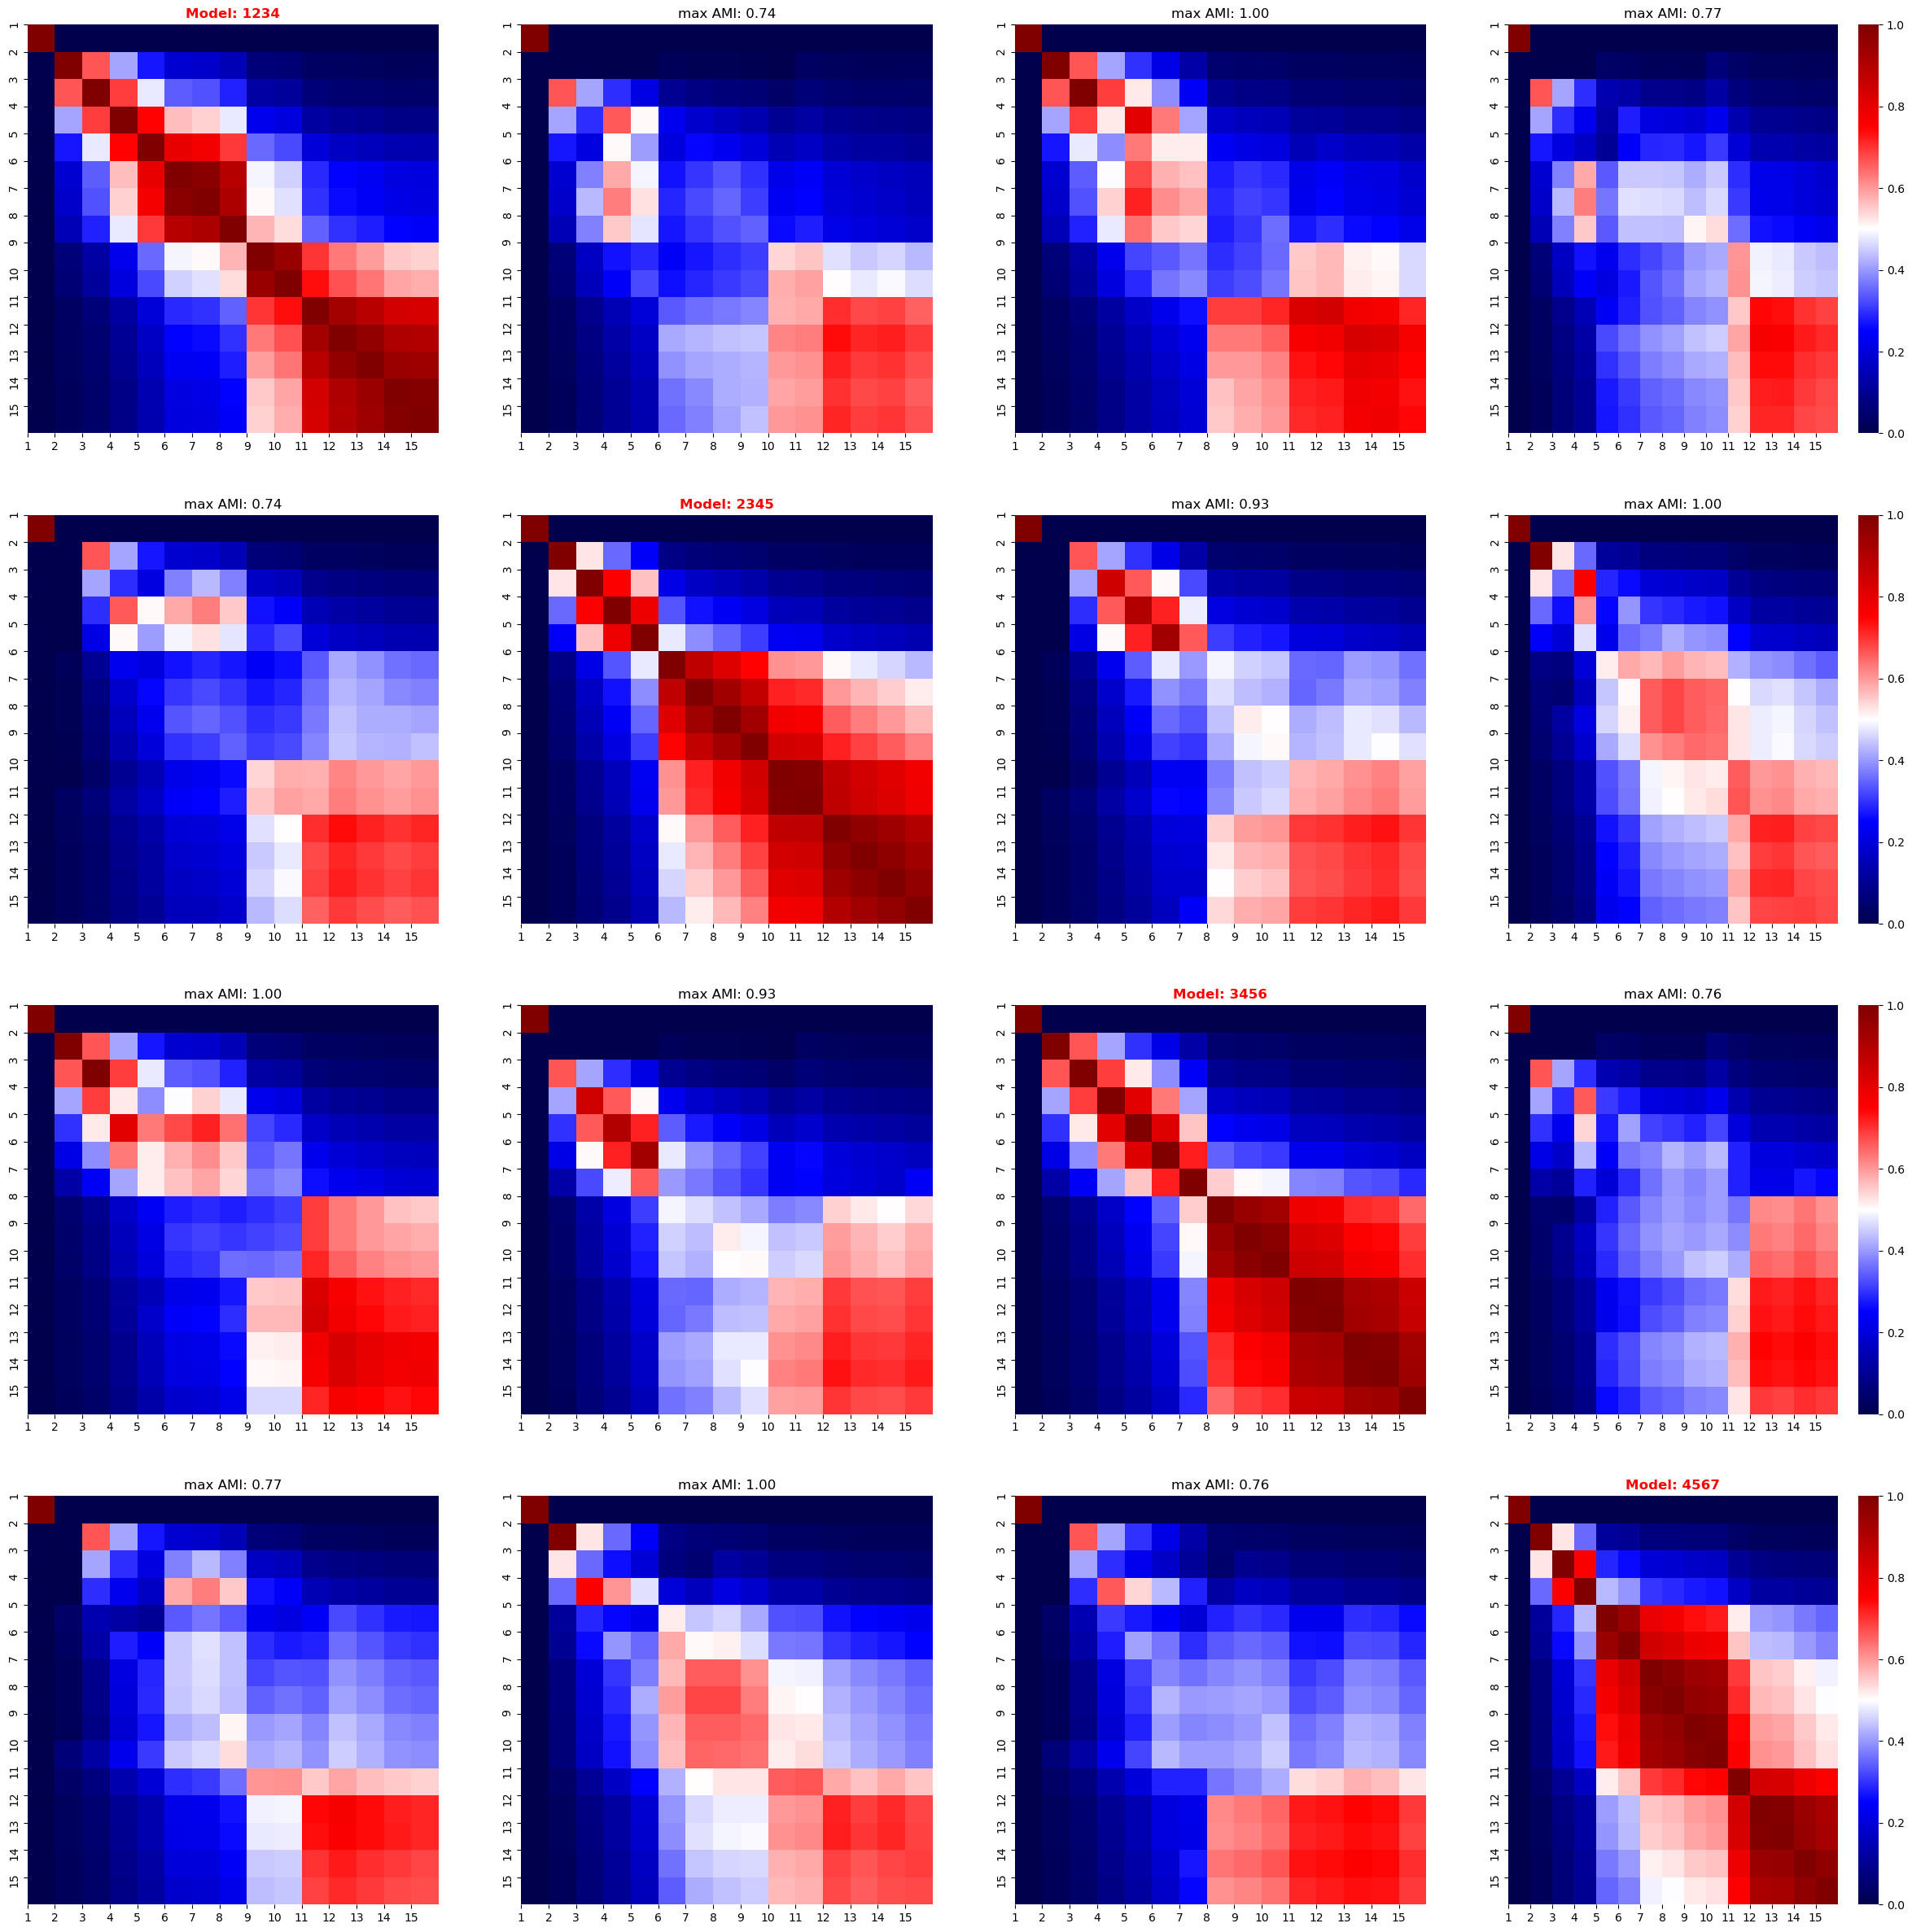

<IPython.core.display.Javascript object>

In [49]:
stability_amis_hallgexgae_feat = stability_cocluster_screen(
    latents_dict_hallgexgae_feat, linkage="average", affinity="euclidean"
)
plot_amis_matrices(seeds, stability_amis_hallgexgae_feat)

100%|██████████| 4/4 [00:16<00:00,  4.00s/it]


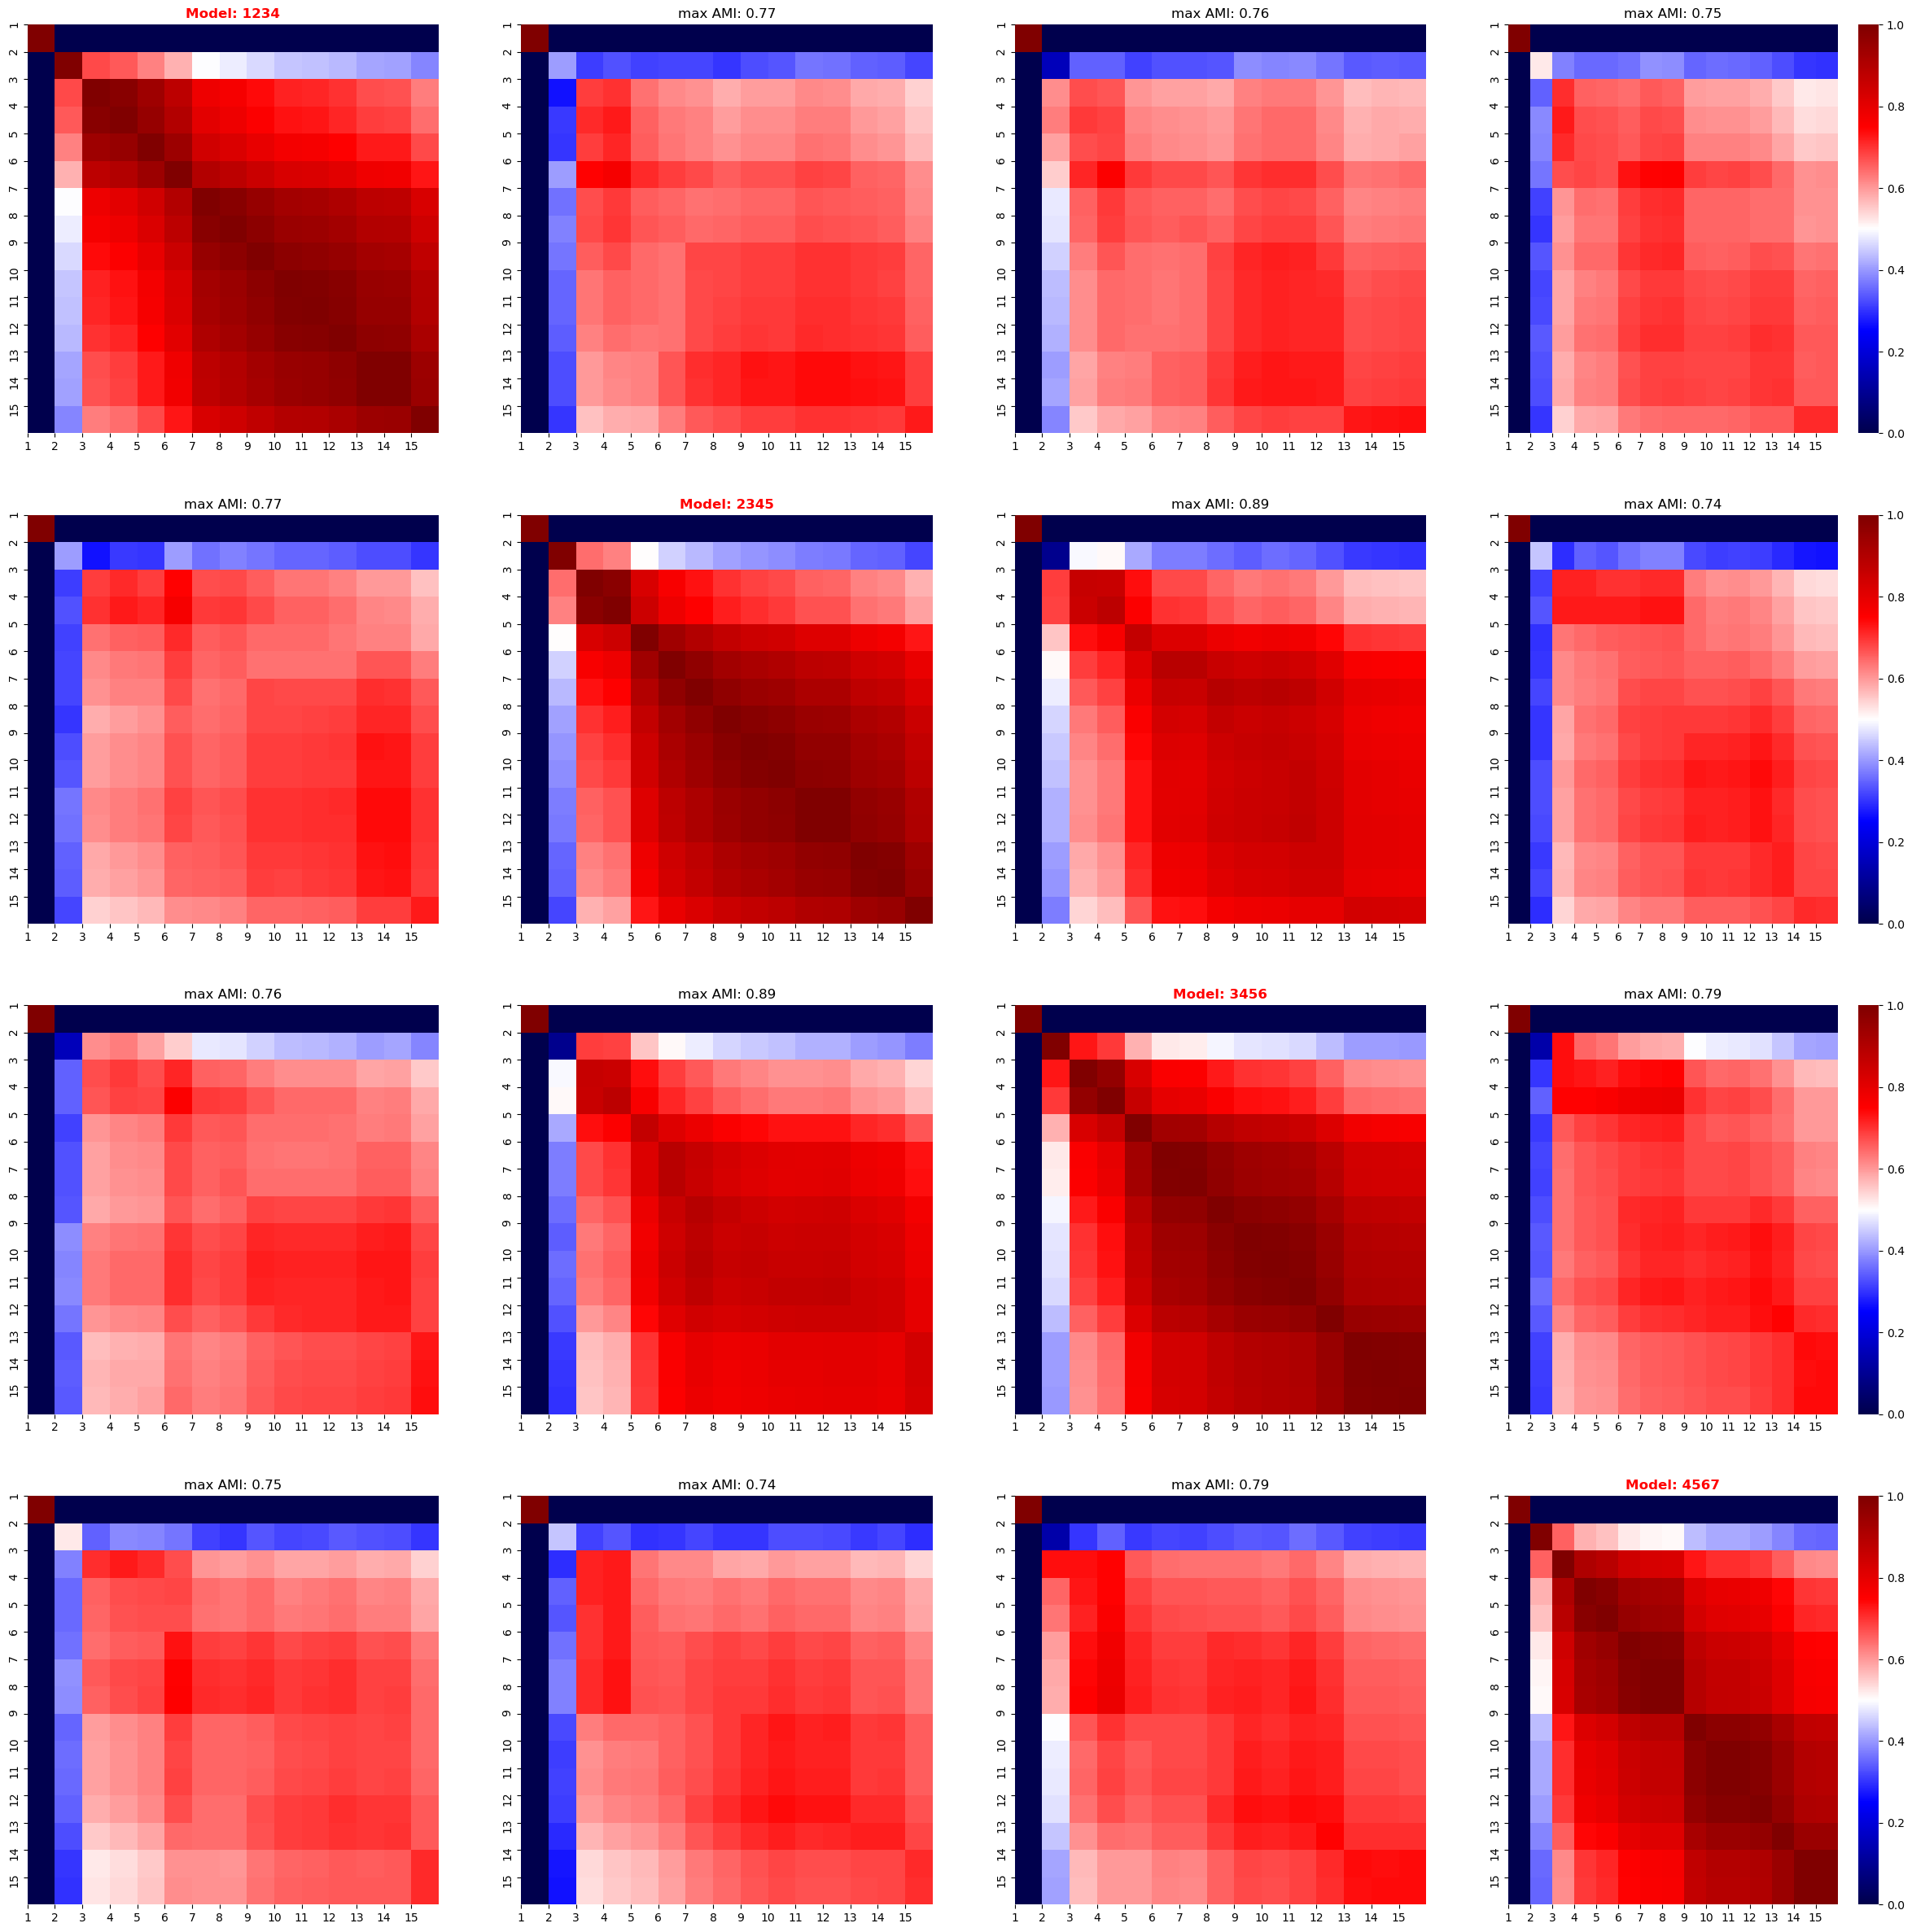

<IPython.core.display.Javascript object>

In [50]:
stability_amis_hallgexgae_feat = stability_cocluster_screen(
    latents_dict_hallgexgae_feat, linkage="average", affinity="cosine"
)
plot_amis_matrices(seeds, stability_amis_hallgexgae_feat)

The plot above suggests that while there exists differences between the inferred latent spaces. The adjusted mutual information is fairly high and the observed structure of the heatmaps on the off-diagnal locations of the above pair-plots look faily similar to the ones on the diagnol suggesting a significant overlap of shared structure.

---

### 3.3. Analyses of the inferred node embeddings

As discussed earlier, we will select the embeddings obtained from the previously described model as the final embeddings of the nodes in our network. We now will visualize and analyze the node embeddings with respect to their clustering to validate that e.g. genes which are known to function together co-cluster in the embedding space.

#### Visualization of the inferred latent space

In [51]:
latents = latents_dict_hallgexgae_feat[1234]

<IPython.core.display.Javascript object>

In [52]:
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [53]:
latents = pd.DataFrame(latents, index=node_names)

<IPython.core.display.Javascript object>

In [54]:
embs = TSNE(
    random_state=1234, perplexity=16, init="pca", learning_rate="auto"
).fit_transform(latents)
embs = pd.DataFrame(embs, columns=["tsne_0", "tsne_1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

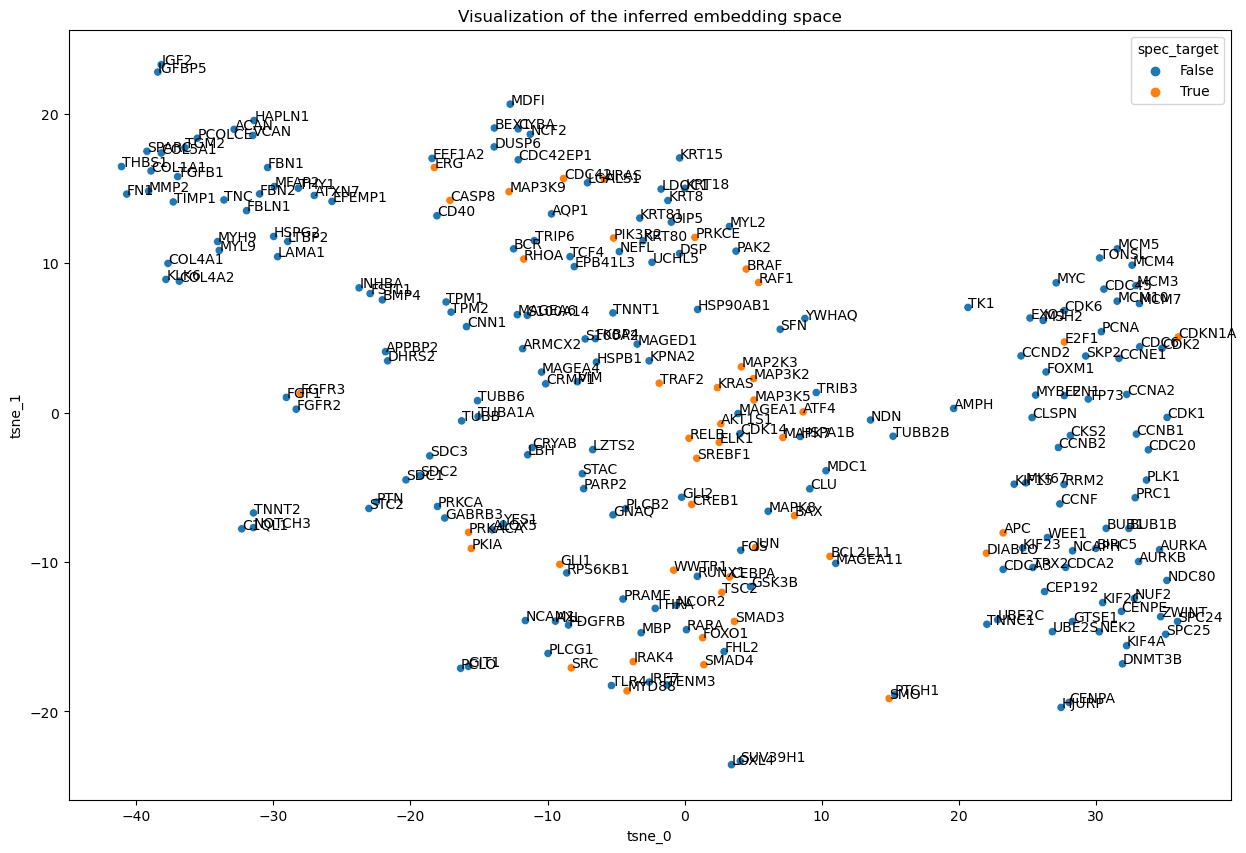

<IPython.core.display.Javascript object>

In [55]:
fig, ax = plt.subplots(figsize=[15, 10])
ax = sns.scatterplot(
    data=embs, x="tsne_0", y="tsne_1", cmap="viridis", hue="spec_target"
)
label_point(
    np.array(embs.loc[:, "tsne_0"]),
    np.array(embs.loc[:, "tsne_1"]),
    np.array(embs.index).astype("str"),
    ax=ax,
)
ax.set_title("Visualization of the inferred embedding space")
plt.show()

#### Clustering of the embedding space

We will now perform a cluster analyses using hierarchical clustering based on the euclidean distances of the individual node embeddings and average linkage.

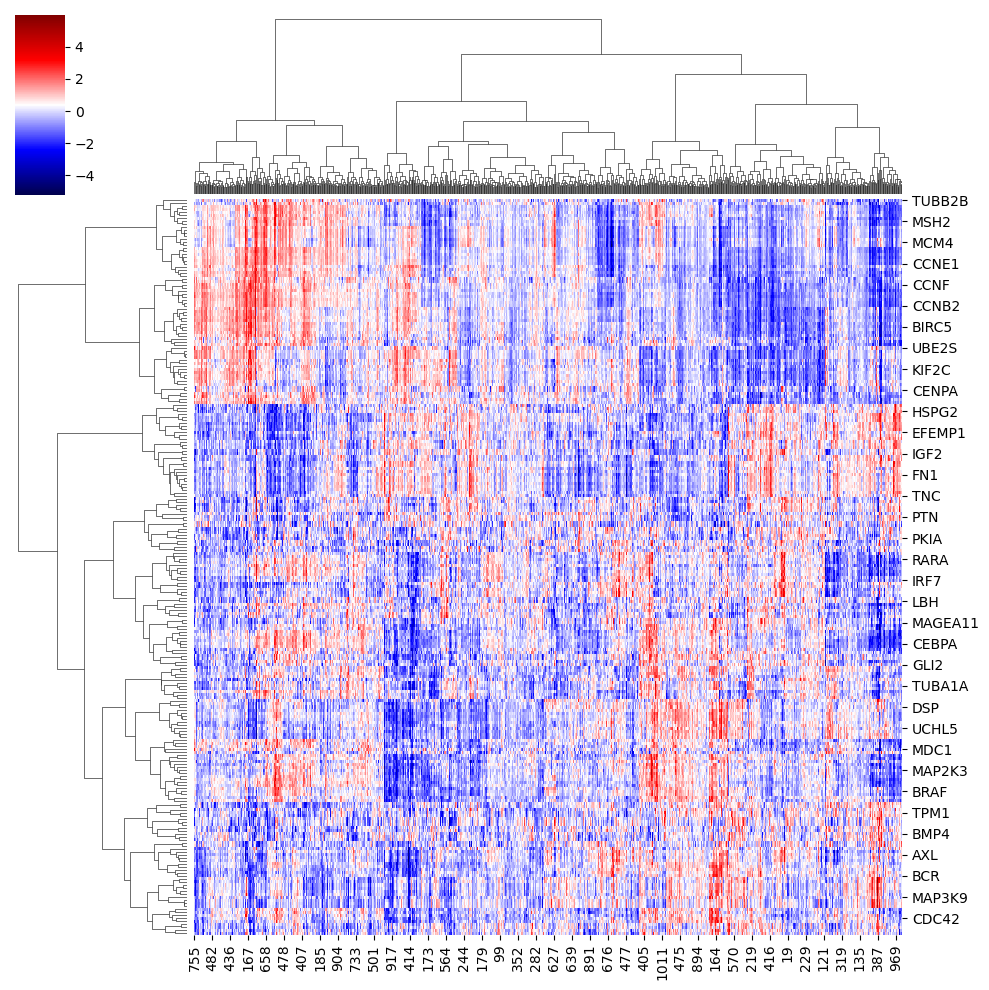

<IPython.core.display.Javascript object>

In [68]:
ax = sns.clustermap(
    latents,
    figsize=[10, 10],
    z_score=0,
    metric="euclidean",
    method="ward",
    cmap="seismic",
)

To better understand the clustering of the latent space, we will run a KMeans clustering analysis. To select the optimal number of clusters we look at a number of scores that have been proposed in the literature for a varying number of clusters. We set the range of clusters to 2-15 as in the previous study.

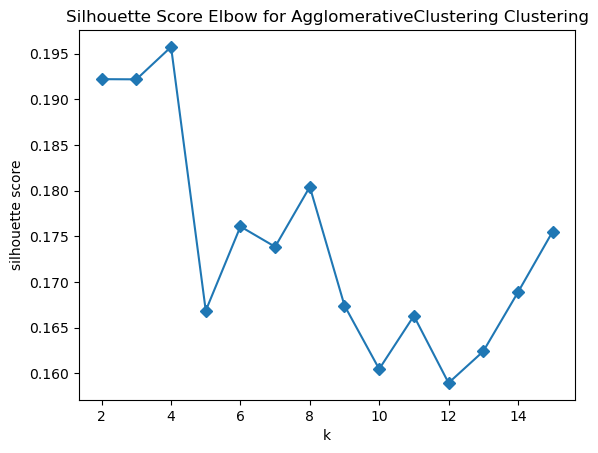

<IPython.core.display.Javascript object>

In [69]:
model = AgglomerativeClustering(affinity="euclidean", linkage="ward")
# model = KMeans(random_state=seed)
visualizer = KElbowVisualizer(
    model, k=15, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(latents)
ax = visualizer.show()

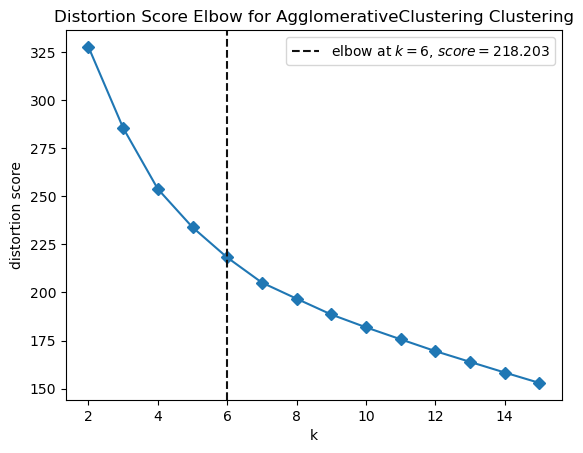

<IPython.core.display.Javascript object>

In [70]:
visualizer = KElbowVisualizer(
    model, k=15, metric="distortion", timings=False, locate_elbow=True
)

visualizer.fit(latents)
ax = visualizer.show()

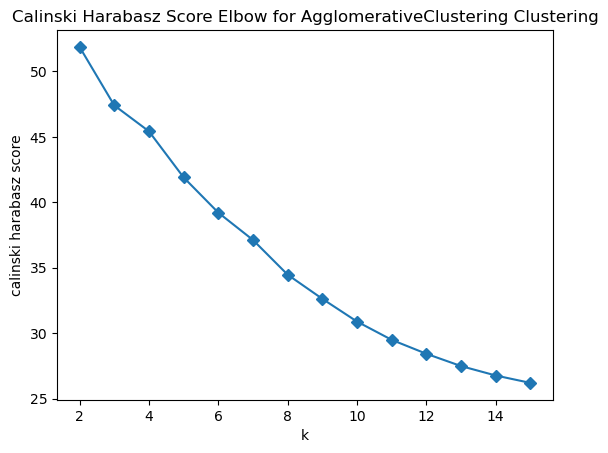

<IPython.core.display.Javascript object>

In [71]:
visualizer = KElbowVisualizer(
    model, k=15, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(latents)
ax = visualizer.show()

When looking at computed cluster scores, we find that the maximum Calinski-Harabasz score is reached for a solution of k=9 clusters, which also matches approximately the elbow of the distortion score. Thus, we decide to cluster the inferred latent space into 9 distinct clusters.

Next, we aim to characterize the meaning of these clusters using a gene ontology analysis to identify the three GO terms associated with the clusters that have the lowest FDR. Clusters with no significant GO terms will be marked accordingly.

In [42]:
print(list(spearman_interactome.nodes()))

['CDCA2', 'APPBP2', 'TK1', 'MMP2', 'PRKACA', 'CDC45', 'NOTCH3', 'SPARC', 'FBN1', 'FBLN1', 'RUNX1', 'SREBF1', 'STAC', 'TNNT1', 'GTSE1', 'TNNC1', 'YWHAQ', 'ERG', 'BIRC5', 'PRKCA', 'ACAN', 'CASP8', 'LZTS2', 'SPC25', 'MAPK7', 'S100A2', 'TUBB2B', 'CDC6', 'DHRS2', 'CEBPA', 'BEX1', 'UCHL5', 'HSPB1', 'WEE1', 'BMP4', 'PRAME', 'MYL2', 'SUV39H1', 'SDC2', 'TNC', 'DIABLO', 'DNMT3B', 'APC', 'TPM1', 'FKBP4', 'MAGEA6', 'LTBP2', 'CNN1', 'CLSPN', 'CRMP1', 'MCM4', 'GLI1', 'PKIA', 'CDKN1A', 'COL4A2', 'MAGEA1', 'MCM5', 'CDC42EP1', 'PCNA', 'JUN', 'NCF2', 'FOS', 'CD40', 'MAGED1', 'FBN2', 'MAP2K3', 'YES1', 'CDCA3', 'BCL2L11', 'AURKA', 'CCND2', 'MAP3K5', 'PRC1', 'TP73', 'CYBA', 'CDK14', 'TIMP1', 'TLR4', 'MAGEA4', 'PLCG1', 'CEP192', 'FOXM1', 'HRAS', 'KRT18', 'NCAPH', 'UBE2S', 'FN1', 'KPNA2', 'PTN', 'MYH9', 'HJURP', 'MAP3K9', 'LGALS1', 'FGFR2', 'CDC42', 'SMAD4', 'UBE2C', 'E2F1', 'BAX', 'CRYAB', 'PDGFRB', 'OIP5', 'VCAN', 'COL5A1', 'MDC1', 'CCNE1', 'ELK1', 'ZWINT', 'FOXO1', 'SRC', 'PCOLCE', 'FGF1', 'PIK3R2', 'AMPH

<IPython.core.display.Javascript object>

In [ ]:
spearman_interactome.edges("ALOX5")

In [72]:
model = AgglomerativeClustering(n_clusters=6, linkage="ward", affinity="euclidean")
# model = KMeans(n_clusters=6, random_state=1234)
cluster_labels = model.fit_predict(latents)
cluster_dict = {}
for cluster_label in np.unique(cluster_labels):
    cluster_dict[cluster_label] = list(
        np.array(list(latents.index))[cluster_labels == cluster_label]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, sorted(v)))
    print("")

Cluster 0: ['ALOX5', 'AMPH', 'APPBP2', 'ARMCX2', 'BMP4', 'C1QL1', 'CCND2', 'CD40', 'CNN1', 'CREB1', 'CRYAB', 'DHRS2', 'EFEMP1', 'FHL2', 'FOXO1', 'FSTL1', 'GABRB3', 'GLI1', 'GLI2', 'GNAQ', 'INHBA', 'IRAK4', 'IRF7', 'LBH', 'LZTS2', 'MAGEA6', 'MBP', 'MYD88', 'NCOR2', 'NDN', 'NOTCH3', 'PARP2', 'PKIA', 'PLCB2', 'PRAME', 'PRKACA', 'PRKCA', 'PTCH1', 'PTN', 'RARA', 'RPS6KB1', 'RUNX1', 'S100A14', 'SDC1', 'SDC2', 'SDC3', 'SMAD3', 'SMAD4', 'SMO', 'STAC', 'STC2', 'TENM3', 'THRA', 'TLR4', 'TNNT2', 'TPM1', 'TPM2', 'TUBB2B', 'WWTR1', 'YES1']

Cluster 1: ['AKT1S1', 'ATF4', 'BAX', 'BCL2L11', 'BRAF', 'CDK14', 'CEBPA', 'CLU', 'CRMP1', 'DSP', 'ELK1', 'EPB41L3', 'FKBP4', 'FOS', 'GSK3B', 'HRAS', 'HSP90AB1', 'HSPA1B', 'HSPB1', 'JUN', 'KPNA2', 'KRAS', 'KRT15', 'KRT18', 'KRT8', 'KRT80', 'KRT81', 'LDOC1', 'LGALS1', 'MAGEA1', 'MAGEA11', 'MAGEA4', 'MAGED1', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAPK7', 'MAPK8', 'MDC1', 'MYL2', 'NEFL', 'OIP5', 'PAK2', 'PIK3R2', 'PRKCE', 'RAF1', 'RELB', 'S100A2', 'SFN', 'SREBF1', 'TCF4', 

<IPython.core.display.Javascript object>

We observe larger clusters and two doublets. Note that the largest cluster seems to still be a little bit under-clustered. However, when rerunning the previously described procedure to sub-cluster cluster 0, we again derive a solution where 90% of all genes form a single large cluster. This might be due to the clustering procedure of the inferred embedding.

Performing a statistical over-representation test using the node set of the derived interactome as the background gene set and correcting for multiple testing using the Benjamini-Hochberg method (cut-off at 0.05), we find the following enrichment of the biological processes according to the org.Hs.eg.db in the respective clusters (shown here are the top-3 annotations when ordered by the FDR):

0. Transcriptional regulation
    * Positive regulation of transcription by RNA polymerase II
    * Positive regulation of cytokine production

1. Cytoskeletal organization (n.s.)
    * Regulation of small GTPase mediated signal transduction
    * Actomyosin structure organization
    * Regulation of actin cytoskeleton organization
    
2. DNA replication
    * DNA-dependent replication
    * Double-strand break repair
    * G1/S transition of mitotic cell cycle

3. ECM interaction
    * ECM organization
    
4. Cell division
    * Cell division
    * Mitotic sister chromatid segregation
    * Mitotic spindle assembly
    
5. Macromolecule processes (n.s.)
    * Macromolecule biosynthetic process
    * Macromolecule catabolic process
    * Organitrogen compound catabolic process

In [ ]:
cluster_label_dict = {
    0: "Transcriptional regulation",
    1: "Cytoskeletal organization (n.s.)",
    2: "DNA replication",
    3: "ECM organization",
    4: "Cell division",
    5: "Macromolecule processes (n.s.)",
}

In [ ]:
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")


embs = TSNE(
    random_state=1234, perplexity=16, init="pca", learning_rate="auto"
).fit_transform(latents)
embs = pd.DataFrame(embs, columns=["tsne_0", "tsne_1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()


embs["cluster"] = cluster_labels
embs["cluster"] = embs.cluster.map(cluster_label_dict)

In [ ]:
plt.style.use("default")
fig, ax = plt.subplots(figsize=[10, 6])
ax = sns.scatterplot(data=embs, x="tsne_0", y="tsne_1", cmap="viridis", hue="cluster")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("tSNE plot of the regulatory embeddings")
plt.show()

We see that the two major clusters are gene involved in cell-cycle regulation and transcriptional and apoptotic regulation.

---

### 3.4. Data export

We will now save the inferred node embeddings for later analyses.

In [86]:
latents.to_csv("../../../data/ppi/embedding/node_embeddings_cv_1024_lp.csv")

<IPython.core.display.Javascript object>

---

## 4. Translational analyses

We will now look at the co-clustering of those embeddings with the ones we obtain for the imaging space.

### 4.1. Read in data

First, we read in the previously computed network embedding serving as a proxy for the regulatory space in U2OS cells as well as the respective image embeddings which we use to model the structural space of those cells. Since, we have many images corresponding to a single over-expression condition we will use their mean embeddings as a description of the structural profile in U2OS cells associated with the respective single-gene OE condition.

In [73]:
node_embs = pd.read_csv(
    "../../../data/ppi/embedding/node_embeddings_cv_1024_lp.csv", index_col=0
)

<IPython.core.display.Javascript object>

In [3]:
label_dict = {
    "AKT1S1": 0,
    "APC": 1,
    "ATF4": 2,
    "BAX": 3,
    "BCL2L11": 4,
    "BRAF": 5,
    "CASP8": 6,
    "CDC42": 7,
    "CDKN1A": 8,
    "CEBPA": 9,
    "CREB1": 10,
    "CSNK1E": 11,
    "CXXC4": 12,
    "DIABLO": 13,
    "E2F1": 14,
    "ELK1": 15,
    "EMPTY": 16,
    "ERG": 17,
    "FGFR3": 18,
    "FOXO1": 19,
    "GLI1": 20,
    "HRAS": 21,
    "IRAK4": 22,
    "JUN": 23,
    "KRAS": 24,
    "MAP2K3": 25,
    "MAP3K2": 26,
    "MAP3K5": 27,
    "MAP3K9": 28,
    "MAPK7": 29,
    "MOS": 30,
    "MYD88": 31,
    "PIK3R2": 32,
    "PKIA": 33,
    "PRKACA": 34,
    "PRKCE": 35,
    "RAF1": 36,
    "RELB": 37,
    "RHOA": 38,
    "SMAD3": 39,
    "SMAD4": 40,
    "SMO": 41,
    "SRC": 42,
    "SREBF1": 43,
    "TRAF2": 44,
    "TSC2": 45,
    "WWTR1": 46,
}
label_dict = {v: k for k, v in label_dict.items()}
img_embs = img_embs = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specificity_target_emb_cv_strat/final_1024/fold_0/test_latents.h5"
)
img_embs.iloc[:, -1] = img_embs.iloc[:, -1].map(label_dict)
img_embs = img_embs.groupby(by="labels").mean()

<IPython.core.display.Javascript object>

---

### 4.2. Analyses of the structural space

To investigate the structural space we will run a similar analyses as in 3.3. First, we will visualize the embeddings using a tSNE plot. Second, we will run an clustering analysis to investigate the local structure of the space.

#### Visualization of the structural space

To visualize the structural space, we will plot the tSNE plot choosing a perplexitiy of 6 which is motivated by the power law for kNN, which is $perplexity \propto \sqrt(N)$.

In [4]:
struct_embs = TSNE(random_state=1234, perplexity=6).fit_transform(img_embs)
struct_embs = pd.DataFrame(
    struct_embs, columns=["tsne_0", "tsne_1"], index=img_embs.index
)

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>

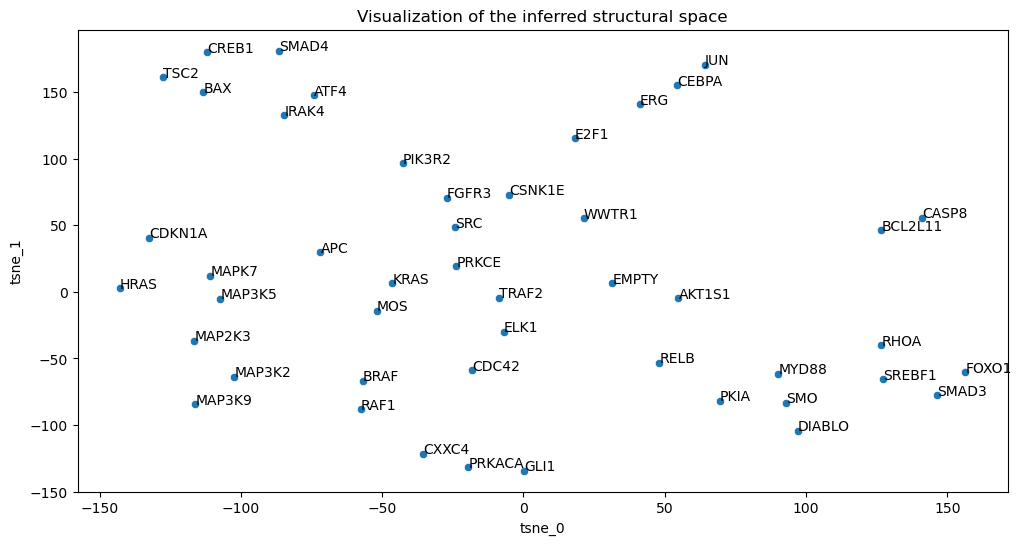

<IPython.core.display.Javascript object>

In [5]:
fig, ax = plt.subplots(figsize=[12, 6])
ax = sns.scatterplot(data=struct_embs, x="tsne_0", y="tsne_1", cmap="viridis")
label_point(
    np.array(struct_embs.loc[:, "tsne_0"]),
    np.array(struct_embs.loc[:, "tsne_1"]),
    np.array(struct_embs.index).astype("str"),
    ax=ax,
)
ax.set_title("Visualization of the inferred structural space")
plt.show()

---

#### Validation of the structural space

To validate the meaningfulness of the structure in the latent space we will assess whether or not the euclidean distance of the mean embeddings for the individual targets of genes part of the same KEGG pathway is greater than the distribution of distances of targets of genes part of different pathways.

In [103]:
all_kegg_genes = []
for v in kegg_gs_dict.values():
    all_kegg_genes.extend(list(v))

<IPython.core.display.Javascript object>

In [107]:
from scipy.spatial.distance import euclidean, cosine

within_pathway_dist = []
outside_pathway_dist = []

kegg_gs_dict = get_genesets_from_gmt_file(
    "../../../data/other/c2.cp.kegg.v7.5.1.symbols.gmt"
)
targets_within_kegg_pws = list(
    set(all_kegg_genes).intersection(set(list(img_embs.index)))
)
for i in range(len(targets_within_kegg_pws) - 1):
    for j in range(i, len(targets_within_kegg_pws)):
        for k, v in kegg_gs_dict.items():
            dist = euclidean(
                np.array(img_embs.loc[targets_within_kegg_pws[i]]).ravel(),
                np.array(img_embs.loc[targets_within_kegg_pws[j]]).ravel(),
            )
            if targets_within_kegg_pws[i] in v and targets_within_kegg_pws[j] in v:
                within_pathway_dist.append(dist)
            else:
                outside_pathway_dist.append(dist)

<IPython.core.display.Javascript object>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

within pathways v.s. between pathways: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val=1.274e-36 U_stat=9.698e+07


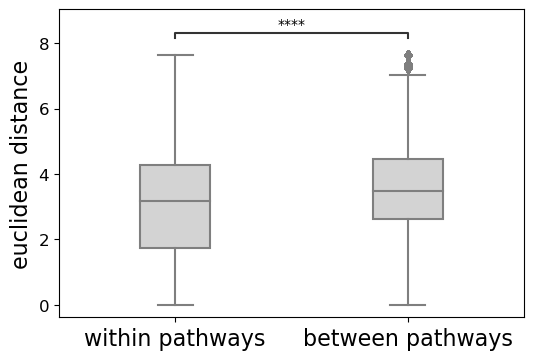

<IPython.core.display.Javascript object>

In [112]:
from statannot import add_stat_annotation

fig, ax = plt.subplots(figsize=[6, 4])
dist_pd = pd.DataFrame(
    np.array(within_pathway_dist + outside_pathway_dist), columns=["mean_euc_dist"]
)
dist_pd["mode"] = np.array(
    ["within pathways"] * len(within_pathway_dist)
    + ["between pathways"] * len(outside_pathway_dist)
)
ax = sns.boxplot(
    data=dist_pd, x="mode", y="mean_euc_dist", ax=ax, width=0.3, color="lightgrey"
)
add_stat_annotation(
    ax,
    data=dist_pd,
    x="mode",
    y="mean_euc_dist",
    box_pairs=[("within pathways", "between pathways")],
    test="Mann-Whitney-ls",
    text_format="star",
    loc="inside",
)
ax.set_ylabel("euclidean distance", size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=12)
ax.set_xlabel("")
# ax.set_title("Distances of averaged structural embeddings", size=14)
plt.show()

In [116]:
pc_gene_df = pd.read_csv(
    "../../../data/other/protein_coding_gene_list.txt", sep="\t", index_col=0
)

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (31,38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<IPython.core.display.Javascript object>

In [124]:
network_gene_df = pc_gene_df.loc[
    pc_gene_df.symbol.isin(list(spearman_interactome.nodes())), ["symbol", "name"]
].sort_values("symbol")
network_gene_df.to_csv("../../../data/other/network_nodes.csv", index=False)

<IPython.core.display.Javascript object>

---

#### Clustering of the structural space

To better understand the clustering of the latent space, we will again run a agglomerative clustering analysis. To select the optimal number of clusters we look at a number of scores that have been proposed in the literature for a varying number of clusters. We set the range of clusters to 2-15 as in the previous study.

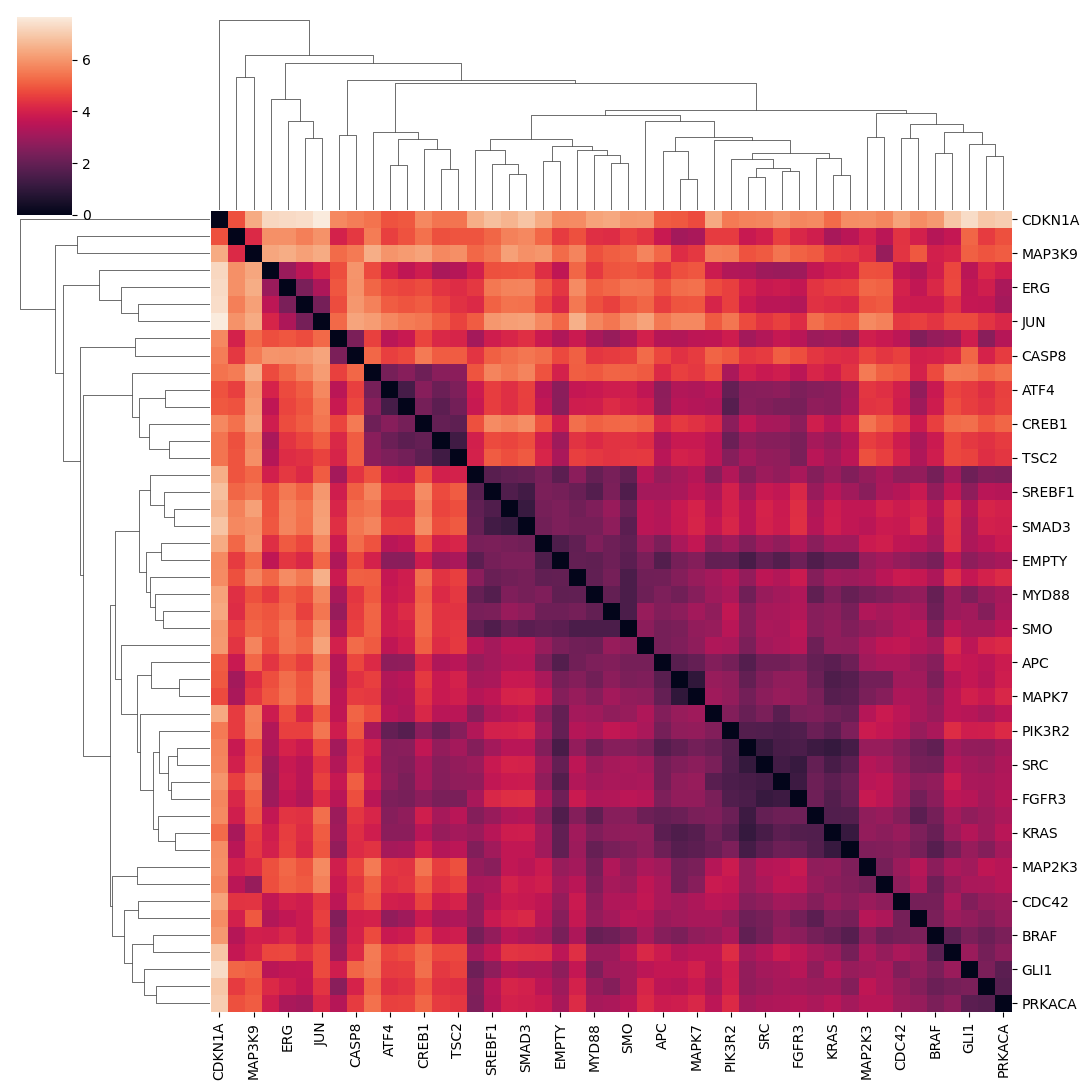

<IPython.core.display.Javascript object>

In [6]:
img_dist = pd.DataFrame(
    squareform(pdist(img_embs, metric="euclidean")),
    columns=list(img_embs.index),
    index=list(img_embs.index),
)
linkage = hc.linkage(sp.distance.squareform(img_dist), method="average")
ax = sns.clustermap(
    img_dist, row_linkage=linkage, col_linkage=linkage, figsize=[11, 11]
)

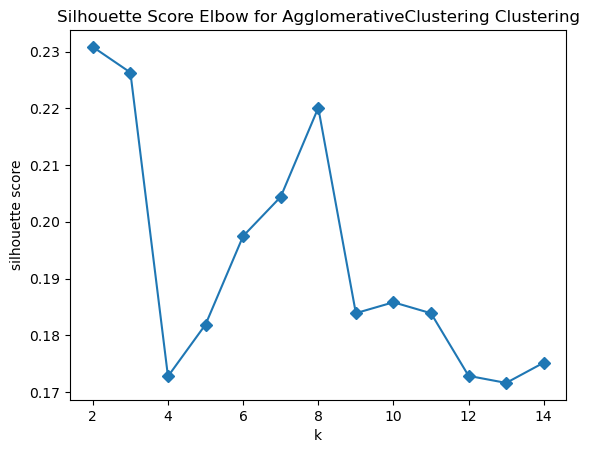

<IPython.core.display.Javascript object>

In [8]:
model = AgglomerativeClustering(linkage="ward")
visualizer = KElbowVisualizer(
    model, k=(2, 15), metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(img_embs)
ax = visualizer.show()

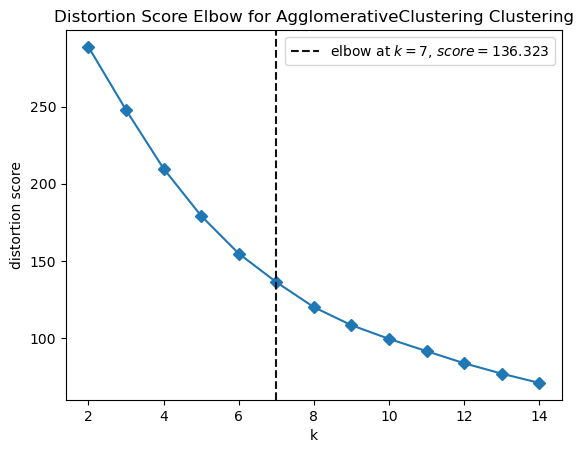

<IPython.core.display.Javascript object>

In [9]:
visualizer = KElbowVisualizer(
    model, k=(2, 15), metric="distortion", timings=False, locate_elbow=True
)

visualizer.fit(img_embs)
ax = visualizer.show()

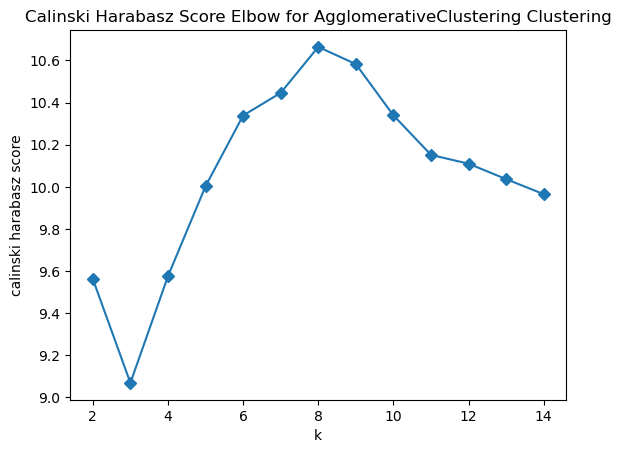

<IPython.core.display.Javascript object>

In [11]:
visualizer = KElbowVisualizer(
    model, k=(2, 15), metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(img_embs)
ax = visualizer.show()

We see that depending on which score we look at the optimal number of clusters seem to be 2,3 or 8. We will choose 8 clusters although this is likely to overcluster the data.

In [15]:
print(list(np.unique(img_embs.index)))

['AKT1S1', 'APC', 'ATF4', 'BAX', 'BCL2L11', 'BRAF', 'CASP8', 'CDC42', 'CDKN1A', 'CEBPA', 'CREB1', 'CSNK1E', 'CXXC4', 'DIABLO', 'E2F1', 'ELK1', 'EMPTY', 'ERG', 'FGFR3', 'FOXO1', 'GLI1', 'HRAS', 'IRAK4', 'JUN', 'KRAS', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MOS', 'MYD88', 'PIK3R2', 'PKIA', 'PRKACA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'SMAD3', 'SMAD4', 'SMO', 'SRC', 'SREBF1', 'TRAF2', 'TSC2', 'WWTR1']


<IPython.core.display.Javascript object>

In [12]:
model = AgglomerativeClustering(n_clusters=8, linkage="ward")
cluster_labels = model.fit_predict(img_embs)
cluster_dict = {}
for cluster_label in np.unique(cluster_labels):
    cluster_dict[cluster_label] = list(
        np.array(list(img_embs.index))[cluster_labels == cluster_label]
    )
for k, v in cluster_dict.items():
    print("Cluster {}: {}".format(k, sorted(v)))
    print("")

Cluster 0: ['APC', 'CSNK1E', 'FGFR3', 'KRAS', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAPK7', 'MOS', 'PIK3R2', 'PRKCE', 'SRC', 'TRAF2', 'WWTR1']

Cluster 1: ['HRAS', 'MAP3K9']

Cluster 2: ['BRAF', 'CDC42', 'CXXC4', 'ELK1', 'GLI1', 'PRKACA', 'RAF1']

Cluster 3: ['AKT1S1', 'DIABLO', 'EMPTY', 'FOXO1', 'MYD88', 'PKIA', 'RELB', 'RHOA', 'SMAD3', 'SMO', 'SREBF1']

Cluster 4: ['CEBPA', 'E2F1', 'ERG', 'JUN']

Cluster 5: ['ATF4', 'BAX', 'CREB1', 'IRAK4', 'SMAD4', 'TSC2']

Cluster 6: ['CDKN1A']

Cluster 7: ['BCL2L11', 'CASP8']



<IPython.core.display.Javascript object>

In [ ]:
struct_cluster_labels = []
for i in range(len(struct_embs)):
    target = list(struct_embs.index)[i]
    clusters = list(cluster_dict.values())
    for j in range(len(cluster_dict)):
        if target in clusters[j]:
            struct_cluster_labels.append(str(j))

In [ ]:
struct_embs["cluster"] = struct_cluster_labels

In [ ]:
fig, ax = plt.subplots(figsize=[12, 6])
ax = sns.scatterplot(
    data=struct_embs,
    x="tsne_0",
    y="tsne_1",
    hue="cluster",
    palette="tab20",
    legend=False,
)
label_point(
    np.array(struct_embs.loc[:, "tsne_0"]),
    np.array(struct_embs.loc[:, "tsne_1"]),
    np.array(struct_embs.index).astype("str"),
    ax=ax,
)
ax.set_xlim([-200, 200])
ax.set_ylim([-200, 200])
ax.set_title("Visualization of the inferred structural space")
plt.show()

We see that the clustering includes three singeltons given by HRAS, CDKN1A and E2F1 a doublet of BCL2L11 and CASP8 (both yielding highly toxic effects) and a tripplet of the three transcription factors CEBPA, ERG and JUN.
However, we also find 3 bigger clusters, which we analyze using a GO analysis to functionally annotate those. Similar to our approach in 3.3. we will report the top-3 terms of the GO analysis for those clusters that reach an FDR < 0.05.

0. MAPK signaling & stress response (not significant)
    * BRAF, CDC42, CXXC4, ELK1, MAP3K2, MAP3K5, MAP3K9, PRKACA, RAF1


1. Intracellular signal transduction (not significant)
    * AKT1S1, DIABLO, EIF4EBP1, MAP2K3, MAP3K5, MAPK7, MKNK1, MYD88, PKIA, PRKCE, RELB, RHOA, SDHA, SRC, SREBF1, STK3, WWTR1


2. Regulation of cell death/response to organic substance (not significant)
    * ATF2, ATF4, BAX, CREB1, IKBKB, IRAK4, SMAD4, TSC2

---

### 4.3. Translation analysis

Next, we will assess the co-clustering of our inferred estimates of the structural and the regulatory space using a similar approach as described earlier to assess the structural similarity of the different network embeddings.

In [76]:
shared_nodes = set(img_embs.index).intersection(node_embs.index)

<IPython.core.display.Javascript object>

In [84]:
ami_img_node = compute_ami_matrix(
    img_embs.loc[shared_nodes],
    node_embs.loc[shared_nodes],
    affinity=["euclidean", "euclidean"],
    linkage="average",
)

<IPython.core.display.Javascript object>

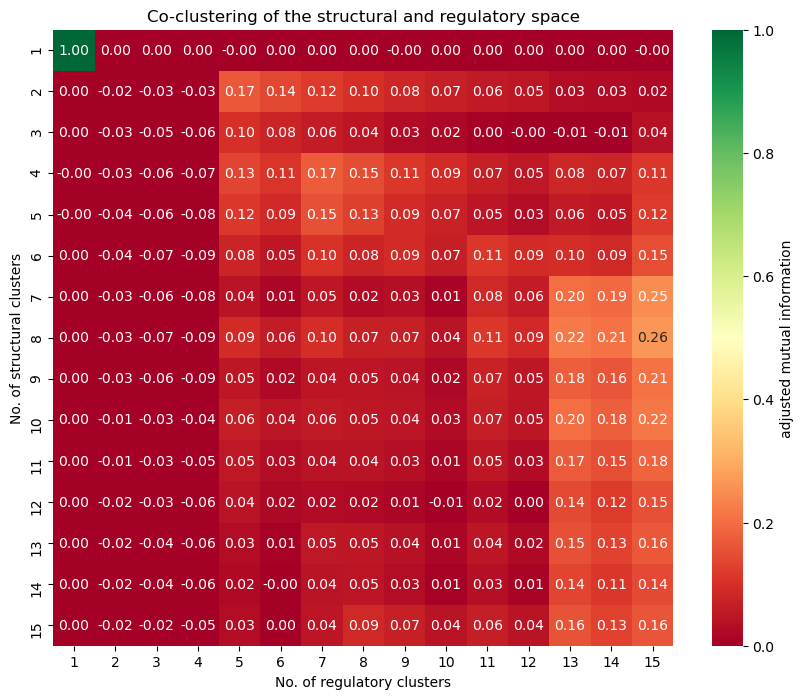

<IPython.core.display.Javascript object>

In [85]:
fig, ax = plt.subplots(figsize=[10, 8])
sns.heatmap(
    ami_img_node,
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    ax=ax,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "adjusted mutual information"},
)
ax.set_xticklabels([i + 1 for i in range(15)])
ax.set_yticklabels([i + 1 for i in range(15)])
ax.set_xlabel("No. of regulatory clusters")
ax.set_ylabel("No. of structural clusters")
ax.set_title("Co-clustering of the structural and regulatory space")
plt.show()

In [79]:
cmap_data = pd.read_csv(
    "/home/paysan_d/PycharmProjects/image2reg/data/gex/cmap/filtered_l5_data_u2os.csv",
    index_col=0,
)
cmap_data.head()
cmap_data = cmap_data.groupby("target").mean()
cmap_data

,CAMSAP2,PPP2R5A,CISD1,AKAP8,TMEM109,CHAC1,FOS,ORC1,AARS,MLLT11,...,ABCF1,SERPINE1,HLA-DMA,STK10,BLCAP,ASCC3,KDELR2,HIST2H2BE,MELK,SMARCA4
target,,,,,,,,,,,,,,,,,,,,,
ACVR1B,-0.655167,-0.396750,0.331467,0.210683,0.514150,-0.159000,0.624683,-0.190117,-0.085033,0.303417,...,0.199633,0.505433,0.127283,-0.197517,0.116783,0.468083,-0.115700,-0.703183,1.093517,0.179967
ADAM17,0.254800,0.040200,-0.251950,-0.434400,0.077000,-0.014950,-0.036950,-1.055250,0.300150,0.283800,...,0.217550,-0.172350,-0.335450,-0.569100,-0.741500,0.278500,-0.040350,0.719400,-0.134250,0.859750
AKT1,-0.316983,-1.004300,0.054283,-0.170033,0.121950,-0.199067,-0.306967,-0.229017,-0.404150,0.809800,...,0.043800,0.421250,0.863717,-0.351917,0.348333,0.346150,0.200217,-0.373067,-0.345750,0.461600
AKT1S1,-0.279350,-1.578925,-0.231600,0.484600,-0.066150,-0.453650,-0.468950,0.062200,-1.380075,-0.571250,...,-0.044450,1.642675,-0.222175,2.352925,-0.783325,0.478025,-0.321900,-0.508475,0.145675,1.385150
AKT2,-1.120450,0.011550,0.044450,1.121250,0.783850,-0.329950,-0.623600,-0.507700,-0.070500,1.409200,...,0.031650,1.131150,0.135300,1.086600,-0.540200,-0.258800,1.202250,-0.479050,0.251100,0.092850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHL,-0.502725,-0.113050,-0.291275,-0.217225,0.385100,0.217425,1.646875,-0.902000,0.434925,-0.120350,...,0.002075,0.539775,0.200750,-0.185000,0.727400,0.230875,0.156575,-0.303300,0.091225,-0.333700
WWTR1,-1.703150,0.548250,-0.748500,0.202400,-0.669150,-0.449450,-0.785300,-0.334300,-0.990450,0.369600,...,-0.371200,-0.655400,0.337250,-0.421750,0.015400,0.365000,0.486250,-0.554250,0.632500,1.310250
XBP1,0.375625,-0.952575,0.676050,0.653825,-0.211475,-0.128275,0.201275,0.601525,0.375450,0.826475,...,-0.196100,-0.027050,-0.292575,0.332575,-0.223800,-0.703625,0.691350,0.388600,0.238750,-0.030825


<IPython.core.display.Javascript object>

In [80]:
ami_img_cmap = compute_ami_matrix(
    img_embs.loc[shared_nodes.intersection(cmap_data.index)],
    cmap_data.loc[shared_nodes.intersection(cmap_data.index)],
    linkage="average",
    affinity="euclidean",
)

<IPython.core.display.Javascript object>

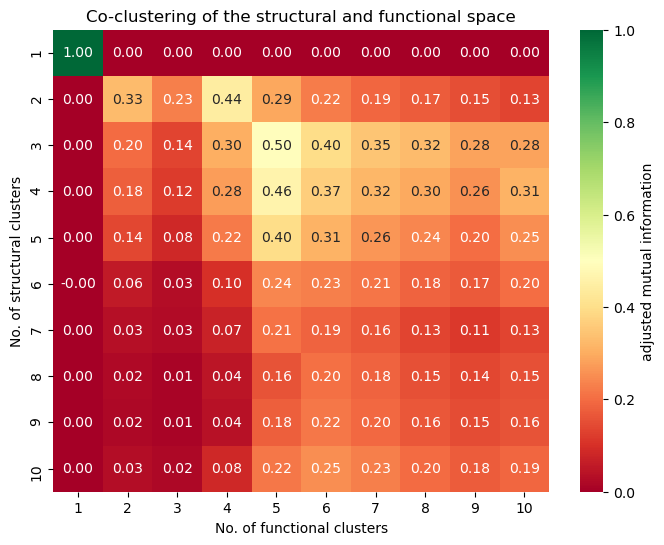

<IPython.core.display.Javascript object>

In [81]:
fig, ax = plt.subplots(figsize=[8, 6])
sns.heatmap(
    ami_img_cmap[:10, :10],
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    ax=ax,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "adjusted mutual information"},
)
ax.set_xticklabels([i + 1 for i in range(10)])
ax.set_yticklabels([i + 1 for i in range(10)])
ax.set_xlabel("No. of functional clusters")
ax.set_ylabel("No. of structural clusters")
ax.set_title("Co-clustering of the structural and functional space")
plt.show()

---

In [82]:
ami_node_cmap = compute_ami_matrix(
    node_embs.loc[shared_nodes.intersection(cmap_data.index)],
    cmap_data.loc[shared_nodes.intersection(cmap_data.index)],
)

<IPython.core.display.Javascript object>

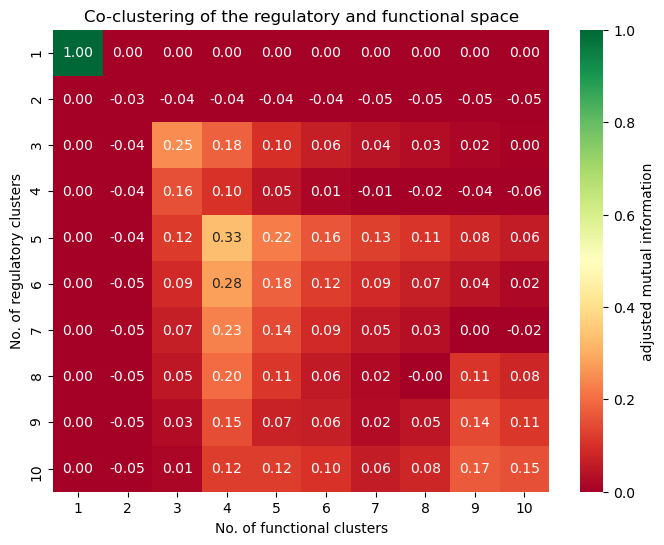

<IPython.core.display.Javascript object>

In [83]:
fig, ax = plt.subplots(figsize=[8, 6])
sns.heatmap(
    ami_node_cmap[:10, :10],
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    ax=ax,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "adjusted mutual information"},
)
ax.set_xticklabels([i + 1 for i in range(10)])
ax.set_yticklabels([i + 1 for i in range(10)])
ax.set_xlabel("No. of functional clusters")
ax.set_ylabel("No. of regulatory clusters")
ax.set_title("Co-clustering of the regulatory and functional space")
plt.show()